In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import time
import logging
import subprocess
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from collections.abc import Iterator

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# For GPU array computation
import cupy as cp

# For GPU dataframe operation
import cudf

# For GPU Model
from cuml.ensemble    import RandomForestClassifier as RF

# Default DASK Libraries and set use GPU's
import dask
import dask_cudf
import dask.array as da
import dask.dataframe as dd
dask.config.set({"dataframe.backend": "cudf"})

# Set for Multi GPU use
from dask_cuda        import LocalCUDACluster
from dask.distributed import Client, wait, progress

# Dask Machine Learning Libraries
import dask_ml
from dask_ml.preprocessing   import StandardScaler
from dask_ml.metrics         import mean_squared_error 
from dask_ml.model_selection import train_test_split
from dask_ml.model_selection import GridSearchCV as GSCV

# Dask Model
from dask_ml.linear_model import LogisticRegression

# For Train XGBoost
import xgboost as xgb

# For Visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import graphviz


In [2]:
cmd = "hostname --all-ip-addresses"
process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
IPADDR = str(output.decode()).split()[0]

cluster = LocalCUDACluster(ip=IPADDR, silence_logs=logging.ERROR, n_workers=1)
client = Client(cluster)

In [3]:
class Timer:
    def __init__(self, name="cpu"):
        self.name = name
        
    def __enter__(self):
        self.start = time.perf_counter()
        
    def __exit__(self, type, value, trackback):
        self.end = time.perf_counter()
        self.execute_time = self.end - self.start
        print(f"{self.name} execute time : {self.execute_time:.4f} seconds")

In [4]:
train_path = "/media/HDD2/Data/AS_Dataset/train.csv"
test_path  = "/media/HDD2/Data/AS_Dataset/test.csv"

In [5]:
with Timer("DASK"):
    train_df = dd.read_csv(train_path)
    test_df  = dd.read_csv(test_path)

DASK execute time : 0.0519 seconds


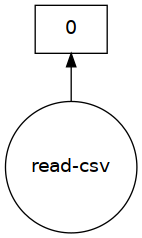

In [6]:
train_df.visualize()

In [7]:
with Timer("DASK"):
    train_df = dd.read_csv(train_path)
    test_df  = dd.read_csv(test_path)

DASK execute time : 0.0294 seconds


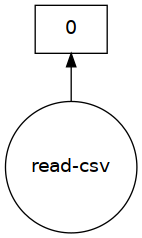

In [8]:
train_df.visualize()

In [9]:
def LabelEncoder(ddf:dd.DataFrame)->dd.DataFrame:
    columns = ddf.columns
    for c in columns:
        categories = ddf[c].compute().unique()
        cat2i   = {c : i for i, c in enumerate(categories.values_host)}
        i2cat   = {i : c for c, i in cat2i.items()}
        ddf[c] = ddf[c].map(cat2i)
    return ddf, i2cat

def LabelDecoder(ddf:dd.DataFrame, i2cat:dict) -> dd.DataFrame:
    ddf["Target"] = ddf["Target"].map(i2cat)
    return ddf

def StandardScaler(ddf:dd.DataFrame) -> dd.DataFrame:
    columns = ddf.columns
    for c in columns:
        mean = ddf[c].mean()
        std  = ddf[c].std()
        ddf[c]   = (ddf[c] - mean) / std
    return ddf

In [10]:
with Timer("DASK"):
    train_df.dropna()
    y_train, i2cat = LabelEncoder(train_df[["Target"]])
    X_train        = train_df.drop(columns=["Target", "id"])
    X_train        = StandardScaler(X_train)
    X_test         = test_df.drop(columns=["id"])
    
X_train = X_train.persist()
X_test  = X_test.persist()
y_train = y_train["Target"].persist()


DASK execute time : 1.5754 seconds


In [11]:
X_train = X_train.persist()
y_train = y_train.persist()
X_test  = X_test.persist()

In [12]:
params = {
    'n_estimator' : 200,
    'objective': 'multi:softmax',
    'num_class': 3,
    'grow_policy': 'lossguide',
    'learning_rate': 0.001,
    'max_leaves': 64,
    'max_depth': 6,
    'eval_metric': 'auc',
    'tree_method': 'gpu_hist',
    'min_child_weight': 7,
    'colsample_bytree': 0.5,
    'reg_lambda': 0.5,
    'reg_alpha': 1
}

model = xgb.dask.DaskXGBClassifier(**params)
model.client = client
model.fit(X_train, y_train)

[15:26:58] task [xgboost.dask-0]:tcp://192.168.0.69:37403 got new rank 0
[15:26:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1701495763888/work/src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.



DaskXGBClassifier(colsample_bytree=0.5, eval_metric='auc',
                  grow_policy='lossguide', learning_rate=0.001, max_depth=6,
                  max_leaves=64, min_child_weight=7, n_estimator=200,
                  num_class=3, objective='multi:softprob', reg_alpha=1,
                  reg_lambda=0.5, tree_method='gpu_hist')

In [13]:
train_out = model.predict(X_train)

In [14]:
prediction = model.predict(X_test)

In [15]:
cp.array(prediction.compute())

array([1, 0, 0, ..., 1, 1, 1])

In [16]:
with Timer("DASK"):
    out_dd = test_df[["id"]]  
    out_dd["Target"] = prediction
    out_dd = LabelDecoder(out_dd, i2cat)
    out_dd.compute().to_csv("./submission.csv", index=False)

DASK execute time : 0.3988 seconds


In [72]:
def make_cv_splits(ddf:dd.DataFrame, n_folds: int = 5)-> Iterator[tuple[dd.DataFrame, dd.DataFrame]]:
    frac = [1 / n_folds] * n_folds
    splits = ddf.random_split(frac, shuffle=True)
    for i in range(n_folds):
        train = [splits[j] for j in range(n_folds) if j != i]
        test  = splits[i]
        yield dd.concat(train), test
        
class StackingClassifier(object):
    def __init__(self, models={'xgb':xgb.dask.DaskXGBClassifier}, C=10, cv=3):       
        self.models          = models
        self.cv              = cv
        self.C               = C
        self.final_estimator = LogisticRegression(C=10)

    def fit(self, train_df:dd.DataFrame, test_df:dd.DataFrame):

        #Make save pred
        self.train_fold_pred = cp.empty([])
        self.train_fold_gt   = cp.empty([])
        self.test_fold_pred  = cp.zeros([len(test_df), self.cv])
            
        X_test, _ = self.make_dataset(test_df)
        
        # K_Fold
        scores = []
        for i, (train, valid ) in enumerate(make_cv_splits(train_df, self.cv)):
            string = f"Fold {i}"
            # Make Dataset
            X_train, y_train = self.make_dataset(train)
            X_valid, y_valid = self.make_dataset(valid)
            gt, _  = LabelEncoder(valid[["Target"]])
            
            now_fold_pred = cp.empty([])
            now_fold_gt   = cp.empty([])
            for model_name, model in self.models:
                strings = string + f" {model_name} Model run..."
                print(strings)
                pred_valid, pred_test = self.train_model(model, X_train, y_train, X_valid, X_test)

                now_fold_pred        = cp.append(now_fold_pred, cp.array(pred_valid))
                now_fold_gt          = cp.append(now_fold_gt, cp.array(gt.compute()["Target"]))
                self.test_fold_pred[:, i] = cp.array(pred_test) 
                
            now_fold_pred = now_fold_pred[1:].reshape([len(X_valid), len(self.models)]).T
            now_fold_gt   = now_fold_gt[1:].reshape([len(X_valid), len(self.models)]).T
            self.train_fold_pred = cp.append(self.train_fold_pred, now_fold_pred)
            self.train_fold_gt   = cp.append(self.train_fold_gt, now_fold_gt)

            # Make Scores
            score = self.accuracy(cp.array(pred_valid), gt.to_dask_array(lengths=True).flatten())
            scores.append(score.reshape(1).persist())
        print(self.train_fold_pred.shape)
            
            
            # self.train_fold_pred = cp.append(self.train_fold_pred, cp.array(pred_valid))
            # self.train_fold_gt   = cp.append(self.train_fold_gt, cp.array(gt.compute()["Target"]))

            # self.test_fold_pred[:, i] = cp.array(xgb.dask.predict(self.client, model, dtest)) 
        
            
        scores = da.concatenate(scores).compute().mean()

    
    def train_model(self, model, X:dd.DataFrame, y:dd.DataFrame, vX:dd.DataFrame, tX:dd.DataFrame):
        model.fit(X,y)
        pred_valid = model.predict(vX.compute())
        pred_test  = model.predict(tX.compute())
        return  pred_valid.compute(), pred_test.compute()

    def accuracy(self, pred, gt):
        return ((gt == pred).astype(int).sum() / len(gt))
        
    def make_dataset(self, ddf:dd.DataFrame) -> dd.DataFrame:
        if "Target" in ddf.columns:
            y, _     = LabelEncoder(ddf[["Target"]])
            X        = ddf.drop(columns=["Target", "id"])
    
        else:
            y        = None
            X        = ddf.drop(columns=["id"]) 
        X        = StandardScaler(X)
        return X.persist(), y["Target"].persist() if y is not None else y

In [68]:
model = xgb.dask.DaskXGBClassifier(**params)
model.client = client

RF_base = RF(n_estimators=200, max_depth=10, n_streams=1)

In [69]:
RF_base.fit(X_train, y_train)

RandomForestClassifier()

In [73]:
stack = StackingClassifier([('xgb', model), ('Random Forest',RF_base)], cv=5)

In [74]:
stack.fit(train_df, test_df)

Fold 0 xgb Model run...


[15:51:39] task [xgboost.dask-0]:tcp://192.168.0.69:37403 got new rank 0
[15:51:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1701495763888/work/src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.



TypeError: Expecting <class 'dask.array.core.Array'> or <class 'dask.dataframe.core.DataFrame'>.  Got <class 'cudf.core.dataframe.DataFrame'>